In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import pickle
import random
import sys

# import ivac
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import extq

In [3]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [4]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [5]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [6]:
plt.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'cm'

# Load data

In [7]:
home_dir = "/project/dinner/scguo/kaiB"
base_dir = "/project/dinner/scguo/kaiB/dga/89"

In [8]:
def load_cvs(base_dir, n_s, n_i):
    raw_feats, fs_qtots, f_rmsds, p_rmsds, r_rmsds, dssps, omegas = [], [], [], [], [], [], []
    for i in range(n_s):
        for j in range(n_i):
            for iso in ("cis", "trans"):
                idx = f"{i:02}_{j:02}_{iso}"
                head = f"{idx}_dga"
                if not os.path.exists(f"{base_dir}/{idx}/outputs/{head}_raw_feats.pkl"):
                    continue
                raw_feats.extend(
                    np.load(f"{base_dir}/{idx}/outputs/{head}_raw_feats.pkl", allow_pickle=True)
                )
                fs_qtots.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_fs_qtots.pkl", allow_pickle=True))
                f_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_f_rmsds.pkl", allow_pickle=True))
                p_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_p_rmsds.pkl", allow_pickle=True))
                r_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_r_rmsds.pkl", allow_pickle=True))
                for k in range(2):
                    if not os.path.exists(f"{base_dir}/{idx}/outputs/{idx}_{k:02}_Omega.npy"):
                        continue
                    omegas.append(np.load(f"{base_dir}/{idx}/outputs/{idx}_{k:02}_Omega.npy"))
                    dssps.append(np.load(f"{base_dir}/{idx}/outputs/{idx}_{k:02}_dssp.npy"))
    return raw_feats, fs_qtots, f_rmsds, p_rmsds, r_rmsds, omegas, dssps

In [9]:
_, fs_qtots, f_rmsds, p_rmsds, r_rmsds, omegas, dssps = load_cvs(base_dir, 7, 32)

In [10]:
n_cis, p63_cis, p70_cis, p71_cis, p72_cis = [], [], [], [], []
for omega in omegas:
    n_cis.append(np.sum((np.abs(omega[:, 3:]) <= (np.pi / 2.0)).astype(int), axis=1))
    p63_cis.append((np.abs(omega[:, 3]) <= (np.pi / 2.0)).astype(bool))
    p70_cis.append((np.abs(omega[:, 4]) <= (np.pi / 2.0)).astype(bool))
    p71_cis.append((np.abs(omega[:, 5]) <= (np.pi / 2.0)).astype(bool))
    p72_cis.append((np.abs(omega[:, 6]) <= (np.pi / 2.0)).astype(bool))

In [11]:
# Adam's CVs
c_gsa1 = np.concatenate([traj[1, :] for traj in fs_qtots])
c_gsa2 = np.concatenate([traj[3, :] for traj in fs_qtots])
c_gsb2 = np.concatenate([traj[5, :] for traj in fs_qtots])

c_fsb1 = np.concatenate([traj[0, :] for traj in fs_qtots])
c_fsb2 = np.concatenate([traj[2, :] for traj in fs_qtots])
c_fsa2 = np.concatenate([traj[4, :] for traj in fs_qtots])

c_green_arr = c_gsa2 - c_fsb2
c_blue_arr = c_gsb2 - c_fsa2
c_orange_arr = c_gsa1 - c_fsb1

c_green = [traj[3, :] - traj[2, :] for traj in fs_qtots]
c_blue = [traj[5, :] - traj[4, :] for traj in fs_qtots]
c_orange = [traj[1, :] - traj[0, :] for traj in fs_qtots]

In [12]:
p_rmsd_arr = np.asarray(p_rmsds).ravel()
f_rmsd_arr = np.asarray(f_rmsds).ravel()
in_fs = np.logical_and(
    c_green_arr < -0.78,
    np.logical_and(c_blue_arr < -0.83, np.logical_and(c_orange_arr < -0.75, f_rmsd_arr < 0.35)),
)

in_gs = np.logical_and(
    c_green_arr > 0.67,
    np.logical_and(c_blue_arr > 0.88, np.logical_and(c_orange_arr > 0.75, p_rmsd_arr < 0.45)),
)

# IVAC

In [13]:
# np.save(f"{base_dir}/dga_data/ivac_10d_10-1000.npy", ivac_trajs)
ivac_trajs = np.load(f"{base_dir}/dga_data/ivac_10d_10-1000.npy")

# $k$-means

In [14]:
dtraj = np.load(f"{base_dir}/dga_data/dtraj_300.npy")

# Utility functions

In [13]:
def split_indices(arrays):
    """Gets the indices for np.split from a
    list of arrays.

    Parameters
    ----------
    arrays : ndarray or list/tuple of ndarray
        Arrays from which to get indices

    Returns
    -------
    traj_inds : list of int
        Frame separators to use in np.split
    """
    traj_lens = [len(traj) for traj in arrays]
    traj_inds = []
    subtot = 0
    for length in traj_lens[:-1]:
        subtot += length
        traj_inds.append(subtot)
    return traj_inds

In [14]:
traj_inds = split_indices(fs_qtots)

# Indicator basis and guess functions

In [15]:
def make_sparse_basis(dtrajs):
    """Converts a discretized trajectory (e.g. from k-means clustering)
    into a sparse basis of indicator functions.

    Parameters
    ----------
    dtrajs : ndarray
        discretized trajectories

    Return
    ------
    basis : scipy.sparse.csr_matrix
    """
    nclusters = len(np.unique(dtrajs))
    rows, cols = [], []
    for i in range(nclusters):
        pts = np.argwhere(dtrajs == i)
        # indices of which frames are in the cluster i
        rows.append(pts.squeeze())
        # all assigned as 1 in the basis
        cols.append(np.repeat(i, len(pts)))
    rows = np.hstack(rows)
    cols = np.hstack(cols)
    data = np.ones(len(rows), dtype=float)
    basis = scipy.sparse.csr_matrix((data, (rows, cols)), shape=(len(dtrajs), nclusters))
    return basis

In [18]:
# split into lists of arrays
basis_arr = make_sparse_basis(np.squeeze(dtraj))
basis_d_arr = basis_arr.copy()
basis_d_arr[in_fs] = 0
basis_d_arr[in_gs] = 0

traj_lens = [len(traj) for traj in raw_feats]
basis, basis_d = [], []
curr = 0
for t_len in traj_lens:
    basis.append(basis_arr[curr : curr + t_len, :-1])
    basis_d.append(basis_d_arr[curr : curr + t_len])
    curr += t_len

traj_inds = split_indices(raw_feats)
guess_fs = np.split(in_fs.astype(float), traj_inds)
guess_gs = np.split(in_gs.astype(float), traj_inds)

print(len(basis), basis[0].shape)

/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


894 (39997, 299)


# Weights, PMF, eq averages, committors

In [16]:
# saved every 50 time steps
lags = np.array([100, 200, 500, 1000, 2000, 5000], dtype=int)
lagtimes = lags * 50

In [17]:
# saved every 50 time steps
lags = np.array([500, 1000, 2000], dtype=int)
lagtimes = lags * 50

In [18]:
weights = np.load(f"{base_dir}/dga_data/weights.npy")[2:5]
print(weights.shape)

(3, 894, 39997)


In [19]:
in_domain = ~(in_fs | in_gs)
in_d = np.split(in_domain, traj_inds)

## Compute committors with memorY

In [24]:
def adjust_forward_committor(forward_q, in_domain, lag):
    result_qp = []
    for qp, d in zip(forward_q, in_domain):
        n = len(d)
        assert len(qp) == n
        tp = extq.stop.forward_stop(d)
        iy = np.minimum(np.arange(lag, n), tp[:-lag])
        result_qp.append(qp[iy])
    return result_qp

In [28]:
# weights = np.load(f"{base_dir}/dga_data/weights.npy", allow_pickle=True)
qp_gs2fs, qp_fs2gs = {}, {}
mems = [1, 3, 4]
for lag, w in zip(lags, weights):
    for mem in mems:
        print(f"Computing committors with lag {lag} and mem {mem}")
        gs2fs = extq.memory.forward_committor(basis_d, w, in_d, guess_fs, lag, mem)
        qp_gs2fs[(lag, mem)] = gs2fs
        fs2gs = extq.memory.forward_committor(basis_d, w, in_d, guess_gs, lag, mem)
        qp_fs2gs[(lag, mem)] = fs2gs

Computing committors with lag 500 and mem 1
Computing committors with lag 500 and mem 3
Computing committors with lag 500 and mem 4
Computing committors with lag 1000 and mem 1
Computing committors with lag 1000 and mem 3
Computing committors with lag 1000 and mem 4
Computing committors with lag 2000 and mem 1
Computing committors with lag 2000 and mem 3
Computing committors with lag 2000 and mem 4


/project/dinner/scguo/extq/src/extq/projection.py:145: RuntimeWarning: invalid value encountered in divide
  return numer / denom


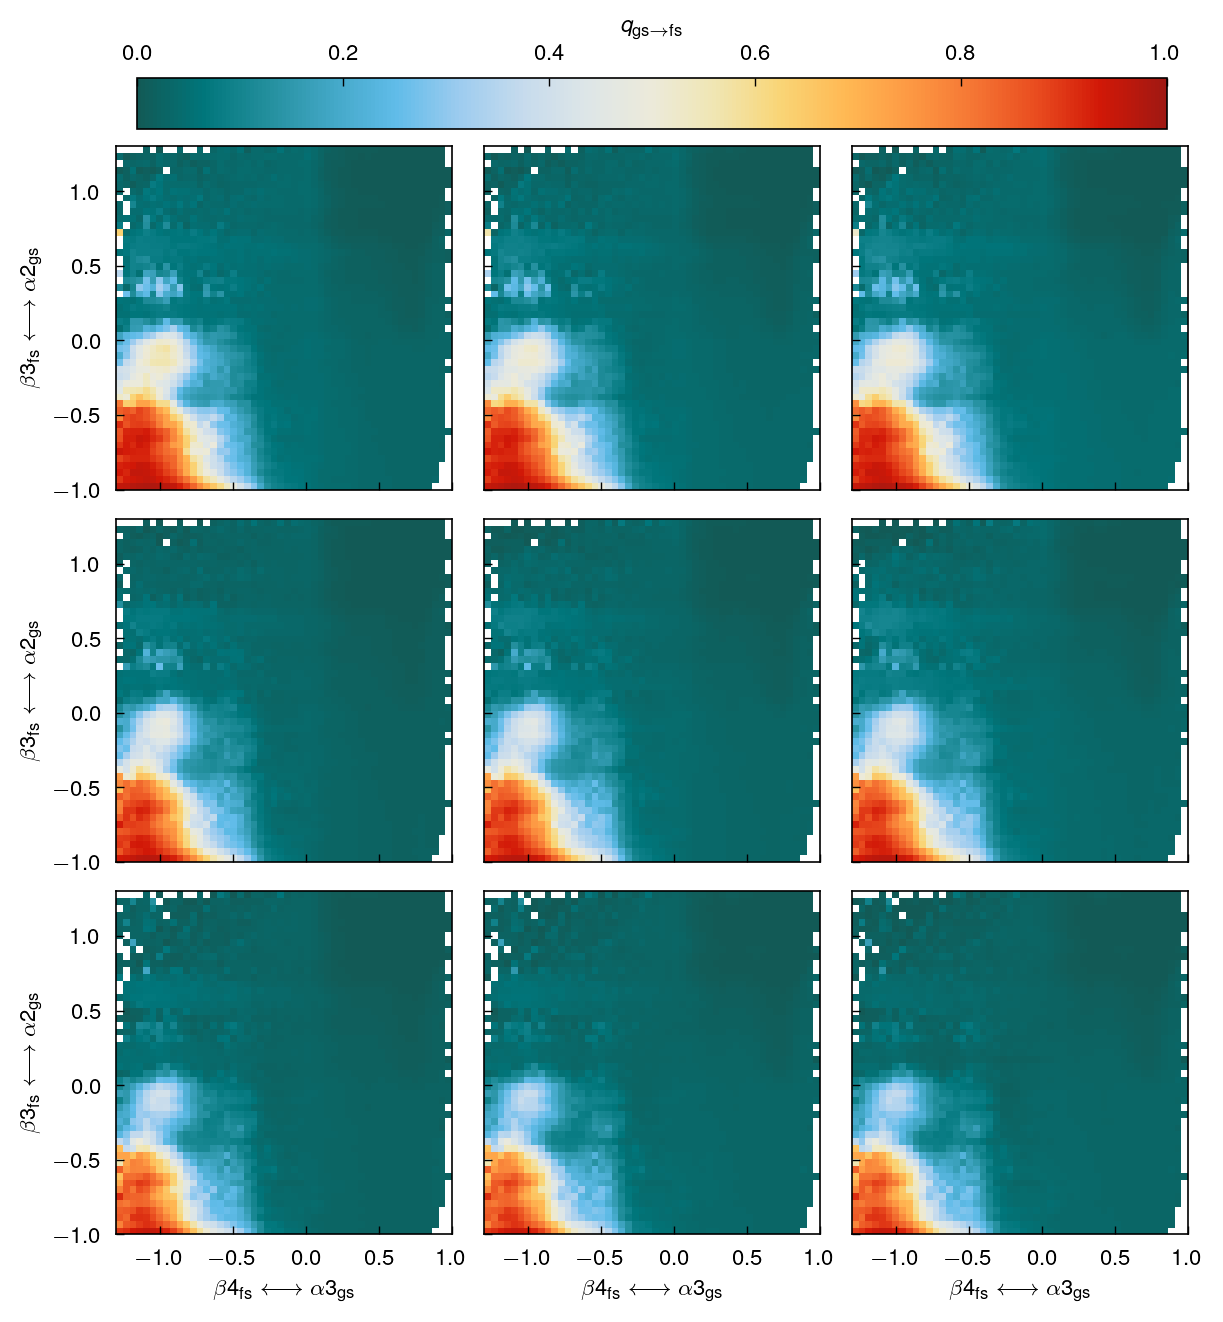

In [29]:
# plot against "GT" and "BT"
fig, axes = plt.subplots(
    nrows=3, ncols=3, figsize=(6, 6.5), dpi=200, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 12, 2)

for i in range(3):
    lag = lags[i]
    w = weights[i]
    # w_delay = [t[:-lag] for t in w]
    # cv1_delay = [t[:-lag] for t in c_green]
    # cv2_delay = [t[:-lag] for t in c_blue]
    for j in range(3):
        ax = axes[i, j]
        q = qp_gs2fs[(lag, mems[j])]
        # qp_delay = adjust_forward_committor(q, in_d, lag)

        # hist = extq.projection.average2d(cv1_delay, cv2_delay, qp_delay, w_delay, xe, ye)
        hist = extq.projection.average2d(c_green, c_blue, q, w, xe, ye)
        pc = ax.pcolormesh(xc, yc, hist.T, cmap="nightfall", vmin=0, vmax=1)
        # ax.contour(xc, yc, hist.T, colors="black", levels=clines)
        ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
        ax.set_ylabel(
            r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
        )
        ax.label_outer()
cb = plt.colorbar(pc, ax=axes[0, :], location='top', label=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")

In [30]:
np.save(f"{base_dir}/dga_data/qp_gs2fs_lag2000_mem4.npy", qp_gs2fs[(2000, 4)])
np.save(f"{base_dir}/dga_data/qp_gs2fs_lag1000_mem4.npy", qp_gs2fs[(1000, 4)])
np.save(f"{base_dir}/dga_data/qp_fs2gs_lag2000_mem4.npy", qp_fs2gs[(2000, 4)])
np.save(f"{base_dir}/dga_data/qp_fs2gs_lag1000_mem4.npy", qp_fs2gs[(1000, 4)])

In [20]:
qp_fs2gs = np.load(f"{base_dir}/dga_data/qp_fs2gs_lag1000_mem4.npy", allow_pickle=True)
qp_gs2fs = np.load(f"{base_dir}/dga_data/qp_gs2fs_lag1000_mem4.npy", allow_pickle=True)

## PLots

/project/dinner/scguo/extq/src/extq/projection.py:145: RuntimeWarning: invalid value encountered in divide
  return numer / denom


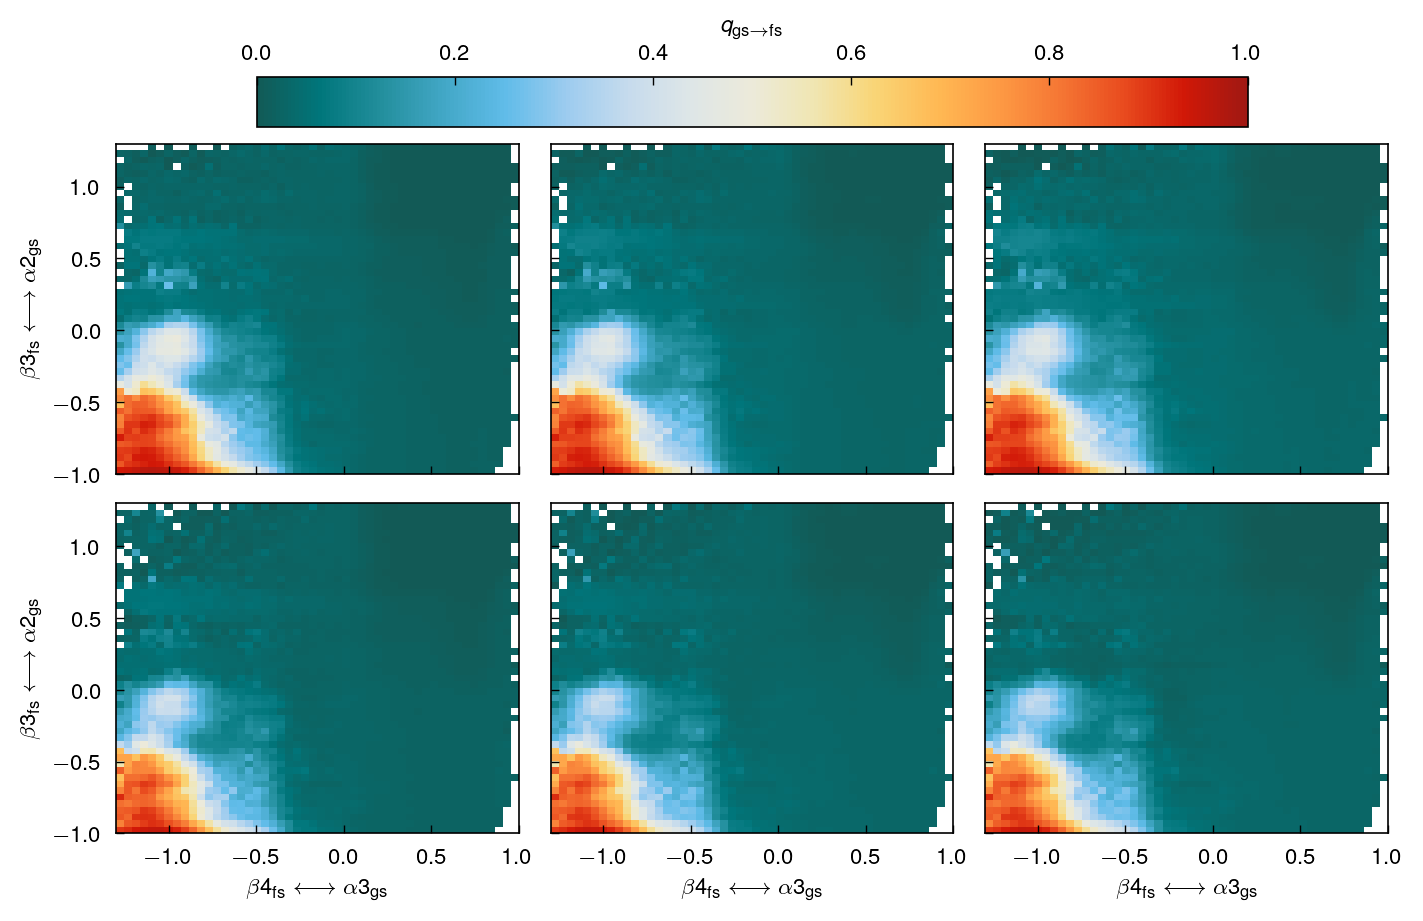

In [31]:
# plot against "GT" and "BT"
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(7, 4.5), dpi=200, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1, 1.3, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 12, 2)

for i in range(2):
    lag = lags[i + 1]
    w = weights[i + 1]
    for j in range(3):
        ax = axes[i, j]
        q = qp_gs2fs[(lag, mems[j])]
        hist = extq.projection.average2d(c_green, c_blue, q, w, xe, ye)
        pc = ax.pcolormesh(xc, yc, hist.T, cmap="nightfall", vmin=0, vmax=1)
        # ax.contour(xc, yc, hist.T, colors="black", levels=clines)
        ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
        ax.set_ylabel(
            r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
        )
        ax.label_outer()
cb = plt.colorbar(pc, ax=axes[0, :], location='top', label=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")

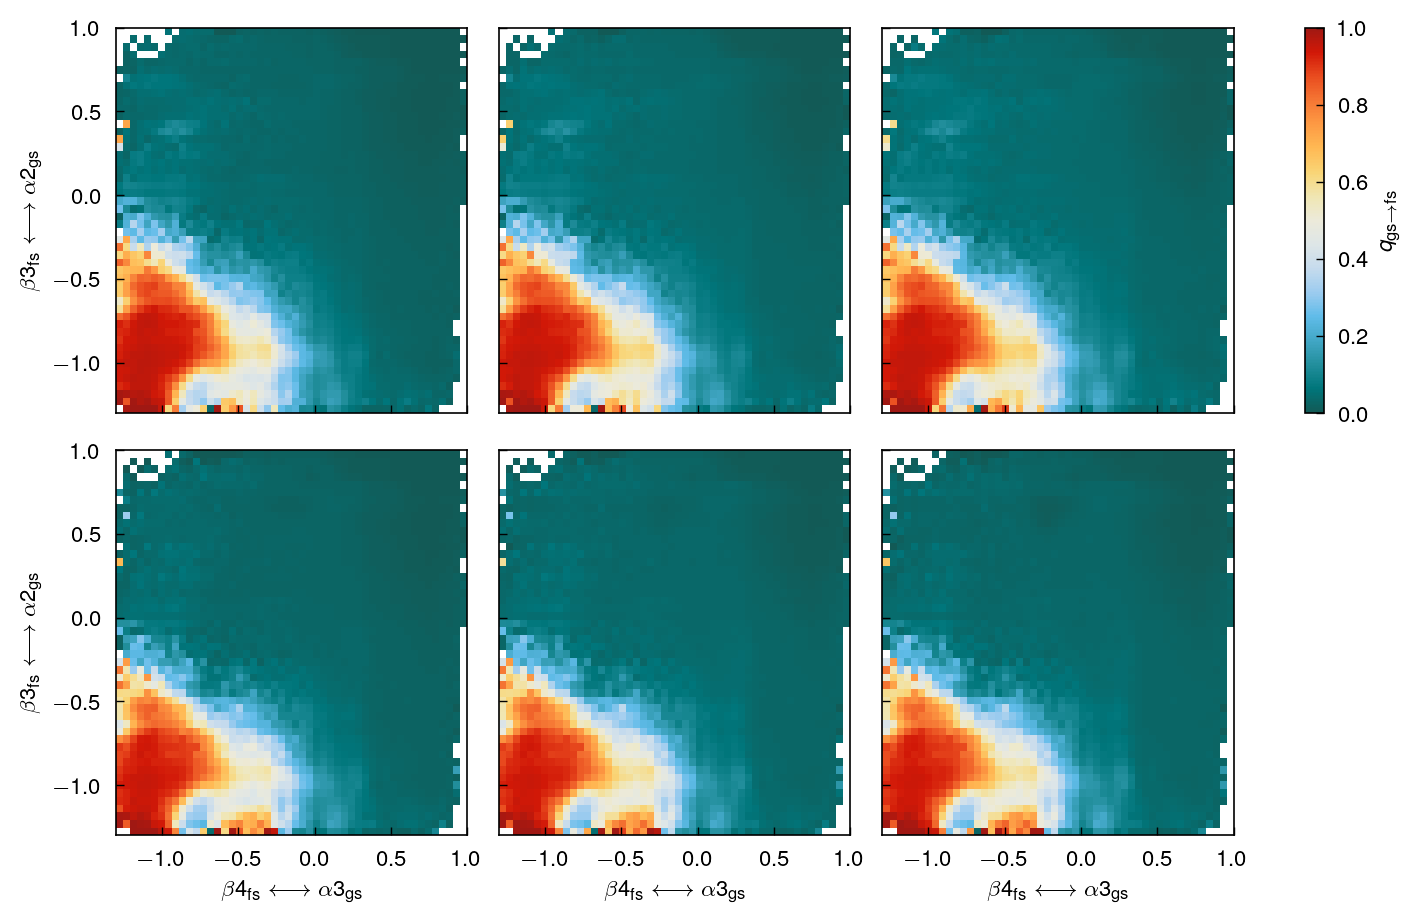

In [32]:
# plot against "GT" and "OT"
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(7, 4.5), dpi=200, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 51)
ye = np.linspace(-1.3, 1, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 12, 2)

for i in range(2):
    lag = lags[i + 1]
    w = weights[i + 1]
    for j in range(3):
        ax = axes[i, j]
        q = qp_gs2fs[(lag, mems[j])]
        hist = extq.projection.average2d(c_green, c_orange, q, w, xe, ye)
        pc = ax.pcolormesh(xc, yc, hist.T, cmap="nightfall", vmin=0, vmax=1)
        # ax.contour(xc, yc, hist.T, colors="black", levels=clines)
        ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
        ax.set_ylabel(
            r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
        )
        ax.label_outer()
cb = plt.colorbar(pc, ax=axes[0, :], location='right', label=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")

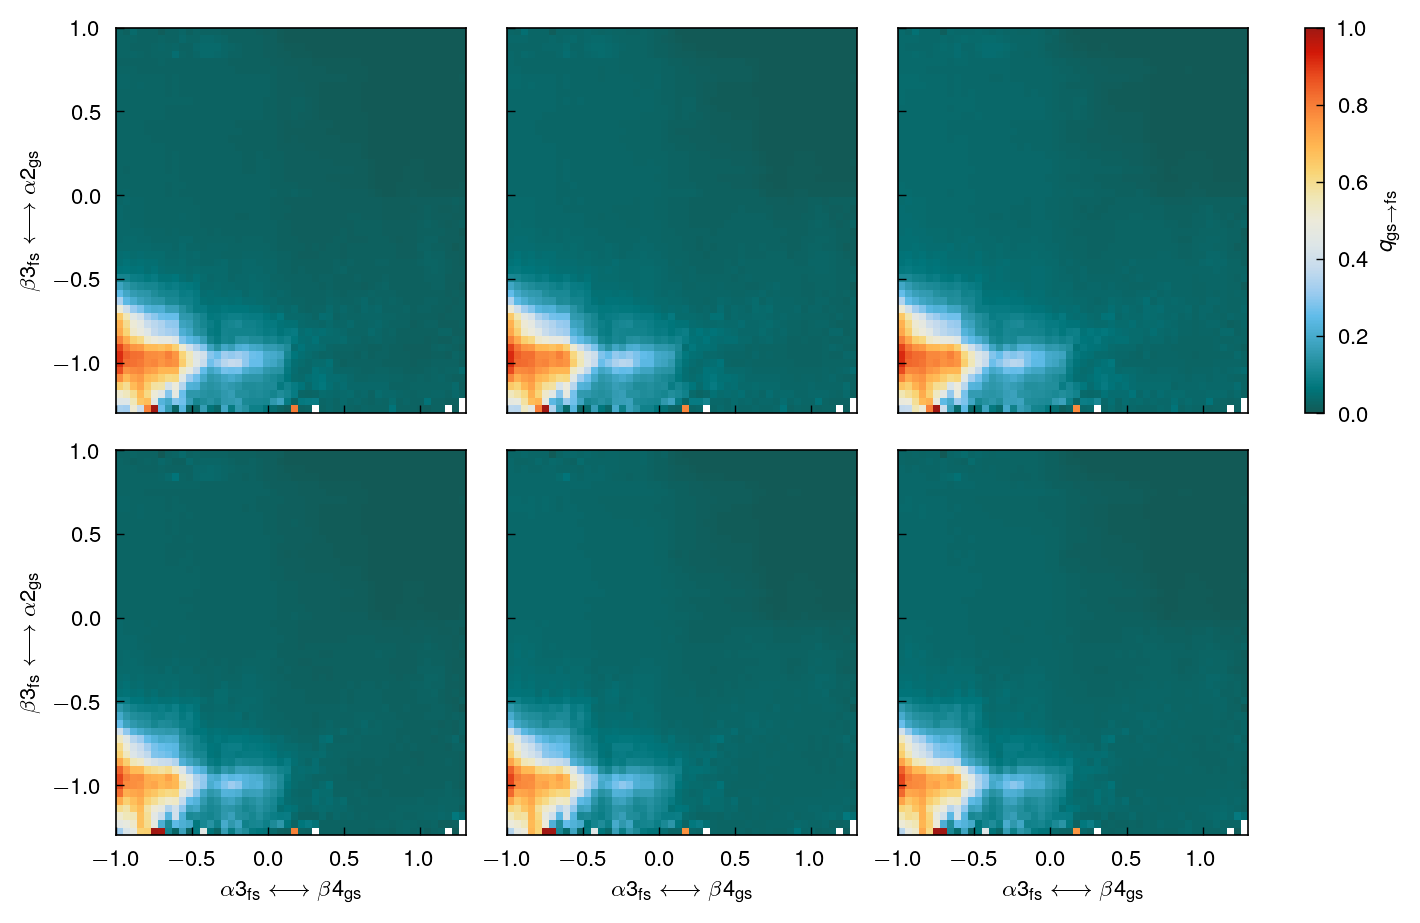

In [33]:
# plot against "BT" and "OT"
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(7, 4.5), dpi=200, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1, 1.3, 51)
ye = np.linspace(-1.3, 1, 51)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 12, 2)

for i in range(2):
    lag = lags[i + 1]
    w = weights[i + 1]
    for j in range(3):
        ax = axes[i, j]
        q = qp_gs2fs[(lag, mems[j])]
        hist = extq.projection.average2d(c_blue, c_orange, q, w, xe, ye)
        pc = ax.pcolormesh(xc, yc, hist.T, cmap="nightfall", vmin=0, vmax=1)
        # ax.contour(xc, yc, hist.T, colors="black", levels=clines)
        ax.set_ylabel(r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$")
        ax.set_xlabel(
            r"$\alpha3_{\mathrm{fs}}\longleftrightarrow\beta4_{\mathrm{gs}}$",
        )
        ax.label_outer()
cb = plt.colorbar(pc, ax=axes[0, :], location='right', label=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")

In [21]:
lag = 2000
names = ["blue", "green", "orange", "r_rmsd", "qp"]
labels = dict(
    blue=r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta4_{\mathrm{gs}}$",
    green=r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$",
    orange=r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
    r_rmsd=r"core RMSD (nm)",
    qp=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$",
)
lims = dict(blue=(-1, 1.3), green=(-1.3, 1), orange=(-1.3, 1), r_rmsd=(0, 1.2), qp=(0, 1))

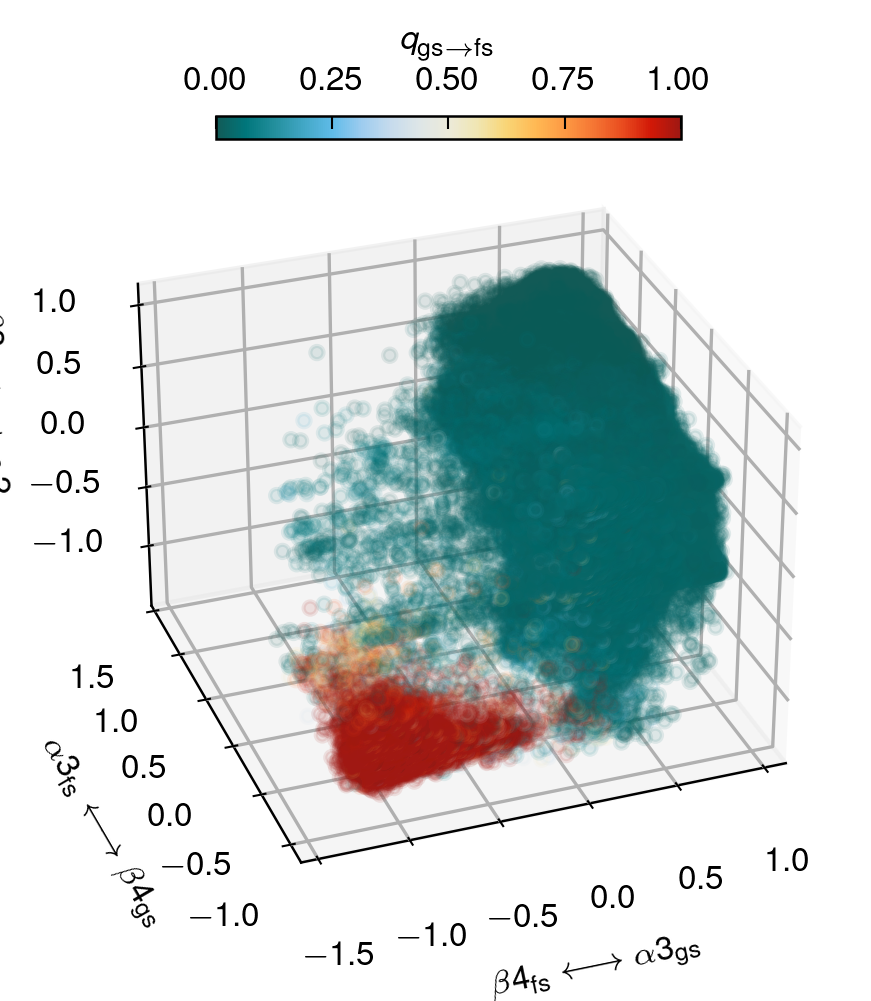

In [22]:
fig = plt.figure(figsize=(4, 4), dpi=300)
q_arr = np.ravel(qp_gs2fs)
N = len(q_arr)
skip = 200
sc_ind = np.random.choice(N, N // skip)

ax = fig.add_subplot(projection="3d")
sc = ax.scatter(
    c_green_arr[sc_ind],
    c_blue_arr[sc_ind],
    c_orange_arr[sc_ind],
    "o",
    c=q_arr[sc_ind],
    cmap="nightfall",
    alpha=0.1,
    s=10,
    rasterized=True,
    vmin=0,
    vmax=1
)
ax.set_xlabel(labels["green"])
ax.set_ylabel(labels["blue"])
ax.set_zlabel(labels["orange"])
ax.grid(True)
cb = plt.colorbar(sc, ax=ax, shrink=0.5, location='top', pad=0, label=labels["qp"])
cb.solids.set(alpha=1)
ax.view_init(elev=30, azim=-110)

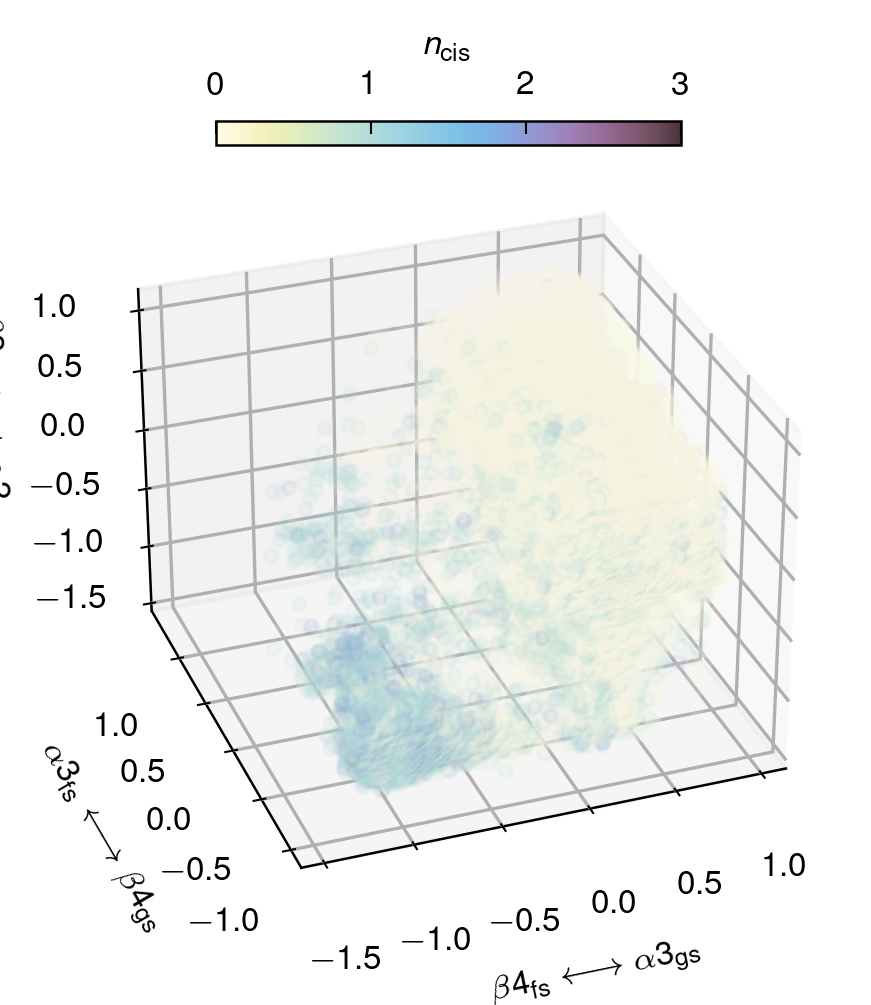

In [23]:
fig = plt.figure(figsize=(4, 4), dpi=300)
q_arr = np.ravel(qp_gs2fs)
N = len(q_arr)
skip = 200
sc_ind = np.random.choice(N, N // skip)

ax = fig.add_subplot(projection="3d")
sc = ax.scatter(
    c_green_arr[sc_ind],
    c_blue_arr[sc_ind],
    c_orange_arr[sc_ind],
    "o",
    c=np.ravel(n_cis)[sc_ind],
    cmap="iridescent",
    alpha=0.1,
    s=10,
    rasterized=True,
    vmin=0,
    vmax=3,
)
ax.set_xlabel(labels["green"])
ax.set_ylabel(labels["blue"])
ax.set_zlabel(labels["orange"])
ax.grid(True)
cb = plt.colorbar(sc, ax=ax, shrink=0.5, location='top', pad=0, label=r"$n_{\text{cis}}$")
cb.solids.set(alpha=1)
ax.view_init(elev=30, azim=-110)

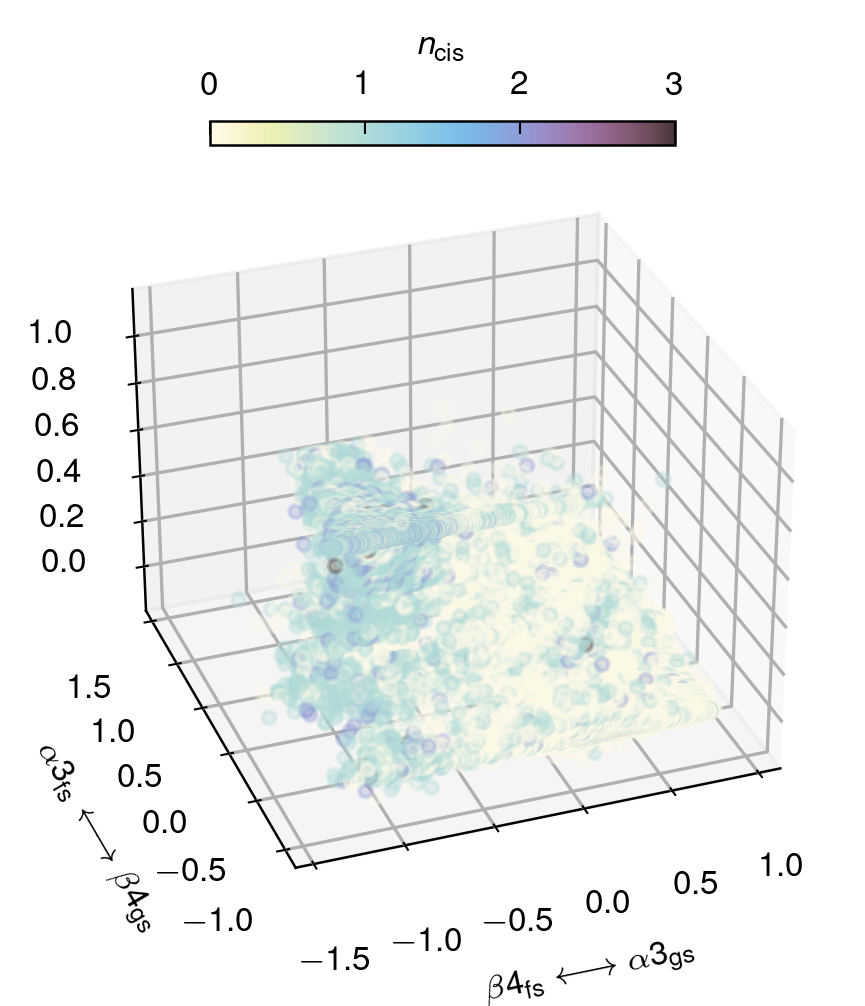

In [24]:
fig = plt.figure(figsize=(4, 4), dpi=300)
q_arr = np.ravel(qp_gs2fs)
N = len(q_arr)
skip = 200
sc_ind = np.random.choice(N, N // skip)

ax = fig.add_subplot(projection="3d")
sc = ax.scatter(
    c_green_arr[sc_ind],
    c_blue_arr[sc_ind],
    q_arr[sc_ind],
    "o",
    c=np.ravel(n_cis)[sc_ind],
    cmap="iridescent",
    alpha=0.3,
    s=10,
    rasterized=True,
    vmin=0,
    vmax=3,
)
ax.set_xlabel(labels["green"])
ax.set_ylabel(labels["blue"])
ax.set_zlabel(labels["qp"])
ax.grid(True)
cb = plt.colorbar(sc, ax=ax, shrink=0.5, location='top', pad=0, label=r"$n_{\text{cis}}$")
cb.solids.set(alpha=1)
ax.view_init(elev=30, azim=-110)

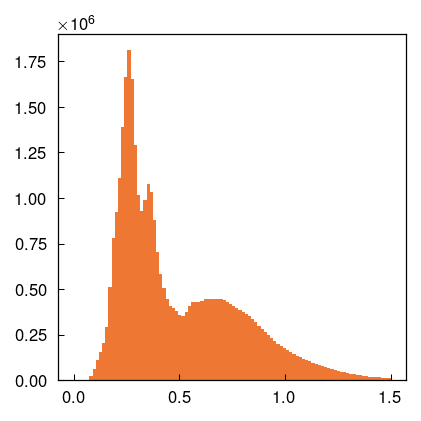

In [63]:
r_rmsds_arr = np.ravel(r_rmsds)
h = plt.hist(r_rmsds_arr, bins=100, range=[0, 1.5])

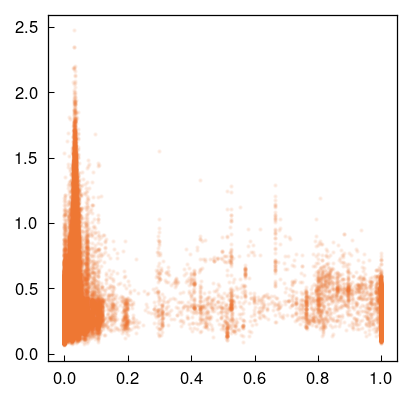

In [27]:
plt.plot(q_arr.clip(min=0, max=1)[sc_ind], r_rmsds_arr[sc_ind], '.', alpha=0.1)

(0.0, 0.2)

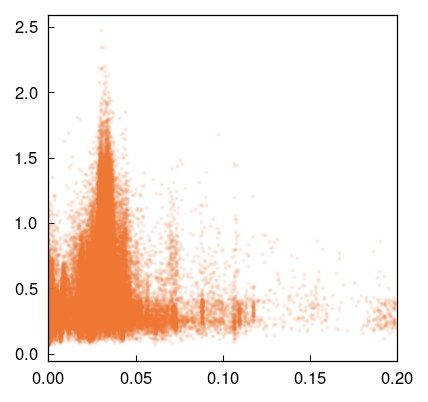

In [28]:
plt.plot(q_arr.clip(min=0, max=1)[sc_ind], r_rmsds_arr[sc_ind], '.', alpha=0.1)
plt.xlim([0, 0.2])

/scratch/local/jobs/11098284/ipykernel_945621/529970973.py:4: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(dens)


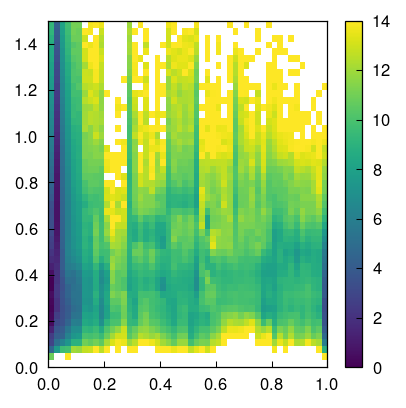

In [30]:
xe = np.linspace(0, 1, 51)
ye = np.linspace(0, 1.5, 51)
dens = extq.projection.density2d(qp_gs2fs, r_rmsds, weights[1], xe, ye)
pmf = -np.log(dens) 
pmf -= np.min(pmf)
plt.pcolormesh(xe, ye, pmf.T, vmax=14)
plt.colorbar()

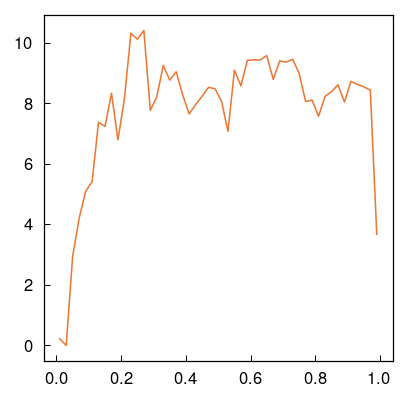

In [31]:
xe = np.linspace(0, 1, 51)
xc = (xe[1:] + xe[:-1]) / 2
dens = extq.projection.density1d(qp_gs2fs, weights[1], xe)
pmf = -np.log(dens)
plt.plot(xc, pmf - np.min(pmf))

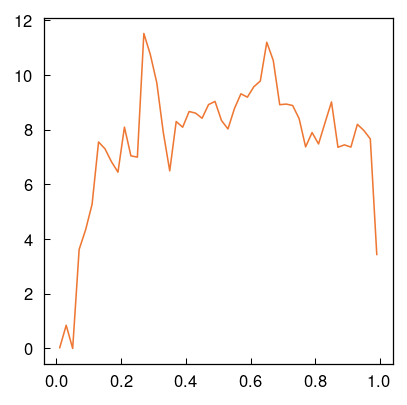

In [45]:
xe = np.linspace(0, 1, 51)
xc = (xe[1:] + xe[:-1]) / 2
dens = extq.projection.density1d(qp_gs2fs[(500, 4)], weights[1], xe)
pmf = -np.log(dens)
plt.plot(xc, pmf - np.min(pmf))

In [25]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

In [26]:
steps, q_inds = bin_inds(qp_gs2fs, qstep=0.1, low=0, hi=1)

In [27]:
steplabels = []
for i, s in enumerate(steps):
    if i % 2 == 0:
        steplabels.append(f"{s+0.05:.2f}")
    else:
        steplabels.append("")

(-1.0, 10.0)

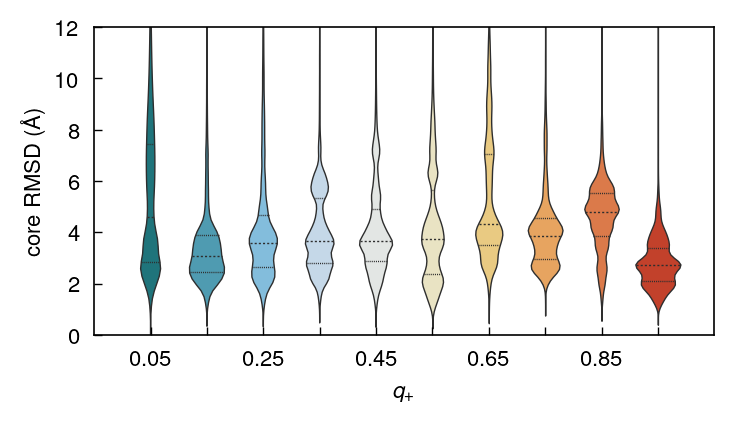

In [35]:
f = plt.figure(figsize=(4, 2), dpi=200)
ax0 = plt.gca()
sns.violinplot(
    ax=ax0,
    data=[r_rmsds_arr[inds] * 10 for inds in q_inds],
    scale="area",
    bw=0.1,
    inner="quartile",
    palette="nightfall",
    orient="v",
    linewidth=0.5,
)

ax0.set_xticklabels(steplabels)
ax0.set_xlabel("$q_+$")
ax0.set_ylabel("core RMSD (Å)")
ax0.set_ylim([0, 12])
ax0.set_xlim([-1, 10])

In [28]:
print("gs state")
n_cis_slice = np.ravel(n_cis)[in_gs]
N = len(n_cis_slice)
for i in range(5):
    print(f"\tFraction n cis = {i}: {np.count_nonzero(n_cis_slice == i) / N * 100:.1f}%")
    
for step, inds in zip(steps, q_inds):
    n_cis_slice = np.ravel(n_cis)[inds]
    N = len(n_cis_slice)
    print(f"q+ = [{step:.1f}, {step+0.1:.1f}]")
    for i in range(5):
        print(f"\tFraction n cis = {i}: {np.count_nonzero(n_cis_slice == i) / N * 100:.1f}%")

print("fs state")
n_cis_slice = np.ravel(n_cis)[in_fs]
N = len(n_cis_slice)
for i in range(5):
    print(f"\tFraction n cis = {i}: {np.count_nonzero(n_cis_slice == i) / N * 100:.1f}%")

gs state
	Fraction n cis = 0: 99.9%
	Fraction n cis = 1: 0.1%
	Fraction n cis = 2: 0.0%
	Fraction n cis = 3: 0.0%
	Fraction n cis = 4: 0.0%
q+ = [0.0, 0.1]
	Fraction n cis = 0: 91.9%
	Fraction n cis = 1: 7.8%
	Fraction n cis = 2: 0.2%
	Fraction n cis = 3: 0.0%
	Fraction n cis = 4: 0.0%
q+ = [0.1, 0.2]
	Fraction n cis = 0: 71.4%
	Fraction n cis = 1: 26.5%
	Fraction n cis = 2: 2.1%
	Fraction n cis = 3: 0.0%
	Fraction n cis = 4: 0.0%
q+ = [0.2, 0.3]
	Fraction n cis = 0: 67.2%
	Fraction n cis = 1: 28.3%
	Fraction n cis = 2: 4.5%
	Fraction n cis = 3: 0.1%
	Fraction n cis = 4: 0.0%
q+ = [0.3, 0.4]
	Fraction n cis = 0: 51.4%
	Fraction n cis = 1: 41.0%
	Fraction n cis = 2: 7.5%
	Fraction n cis = 3: 0.1%
	Fraction n cis = 4: 0.0%
q+ = [0.4, 0.5]
	Fraction n cis = 0: 56.8%
	Fraction n cis = 1: 38.0%
	Fraction n cis = 2: 5.2%
	Fraction n cis = 3: 0.0%
	Fraction n cis = 4: 0.0%
q+ = [0.5, 0.6]
	Fraction n cis = 0: 50.2%
	Fraction n cis = 1: 39.9%
	Fraction n cis = 2: 9.5%
	Fraction n cis = 3: 0.4%

# SS

In [29]:
def compute_per_res_prob_ss(dssp):
    total = len(dssp)
    prob_helix = np.count_nonzero(dssp == 0, axis=0) / total
    prob_strand = np.count_nonzero(dssp == 1, axis=0) / total
    prob_coil = np.count_nonzero(dssp == 2, axis=0) / total
    assert np.allclose(prob_helix + prob_strand + prob_coil, 1)
    return prob_helix, prob_strand, prob_coil

Text(0, 0.5, 'Probability\n$\\beta$-strand$\\qquad$$\\alpha$-helix')

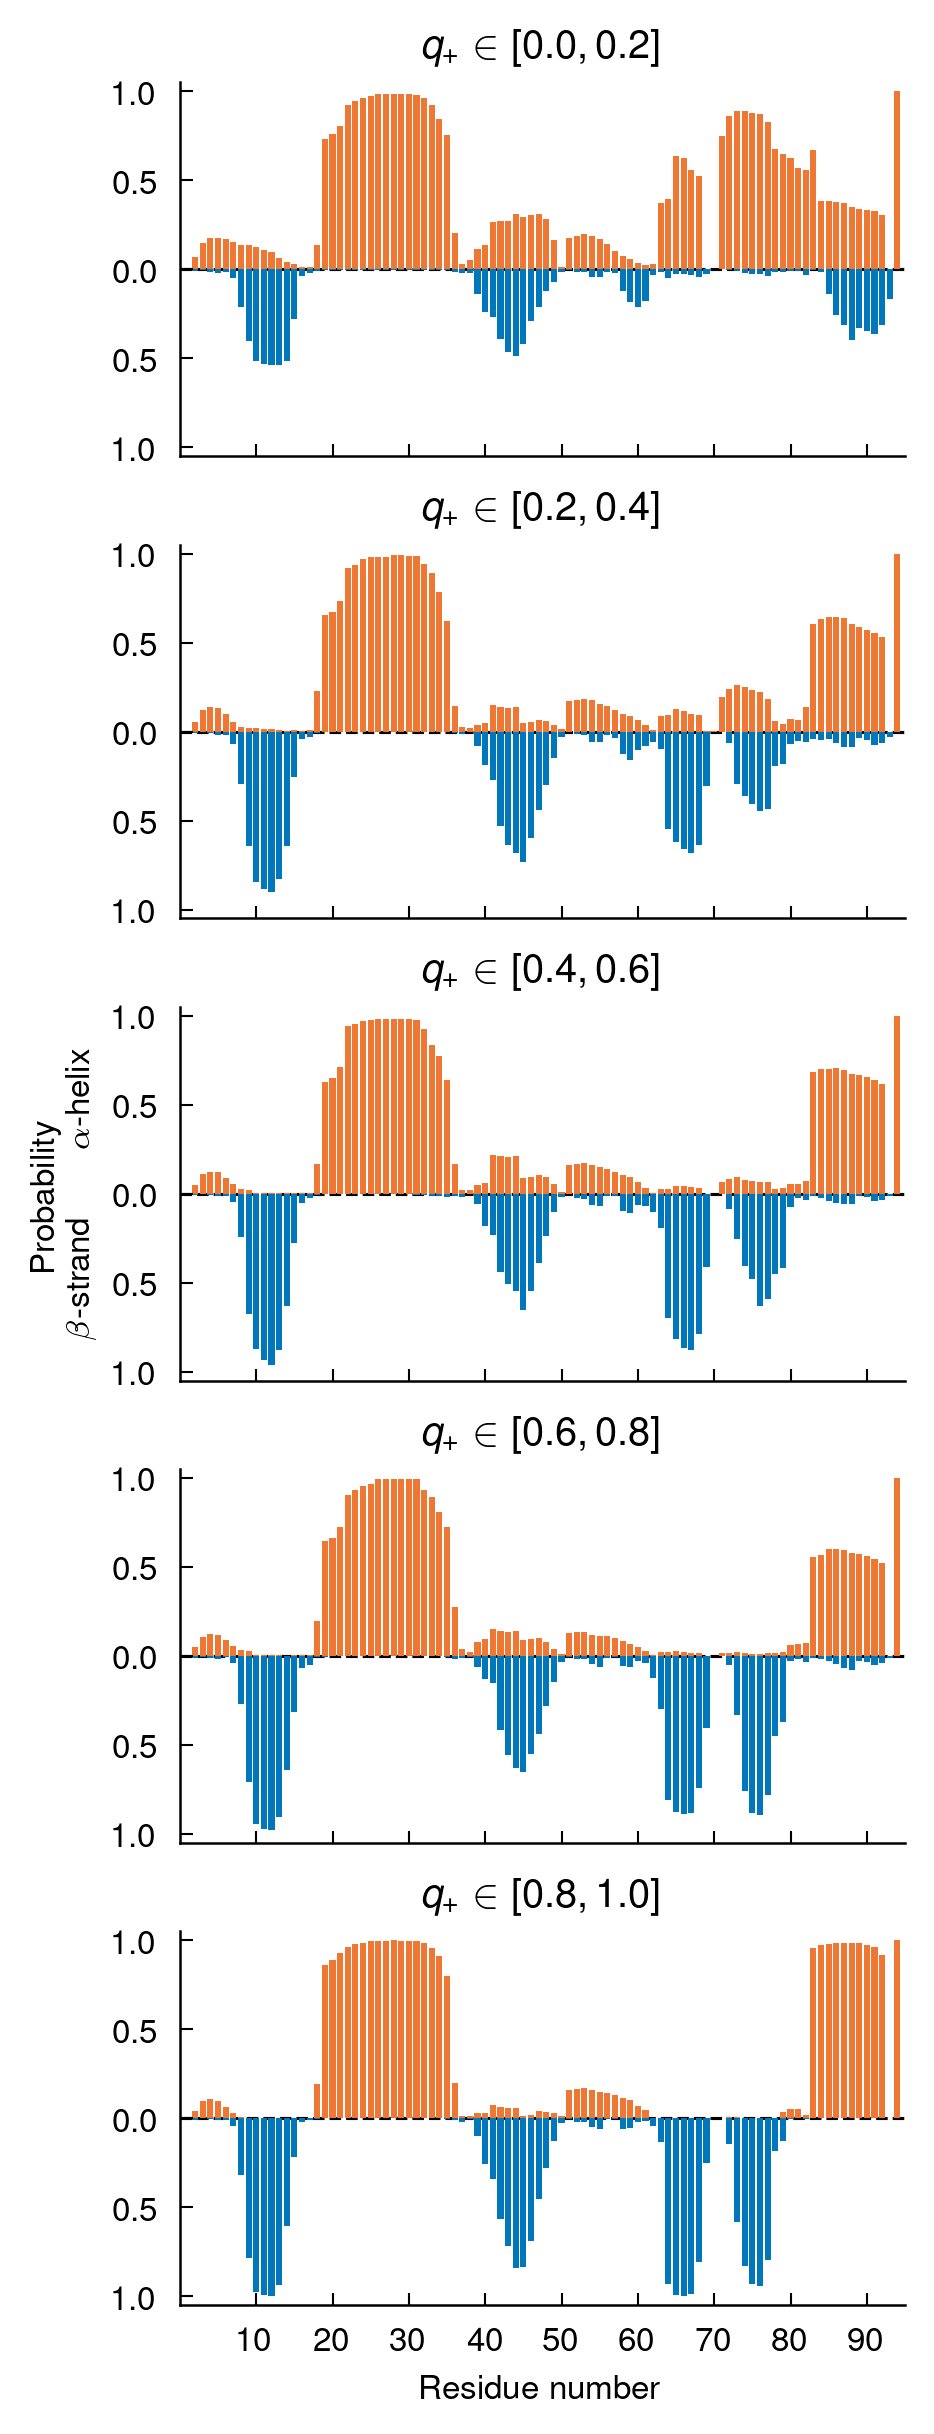

In [30]:
steps, q_inds = bin_inds(qp_gs2fs, qstep=0.2, low=0, hi=1)
dssp_arr = np.concatenate(dssps)

fig, axes = plt.subplots(nrows=5, figsize=(3, 8), dpi=300, sharex=True, sharey=True, constrained_layout=True)
for ax, step, inds in zip(axes.flat, steps, q_inds):
    prob_helix, prob_strand, prob_coil = compute_per_res_prob_ss(dssp_arr[inds])
    ax.bar(range(len(prob_coil)), prob_helix, color="C0", align='center')
    ax.bar(range(len(prob_coil)), -prob_strand, color="C1", align='center')
    ax.set_xlim([-1, len(prob_coil)])
    ax.set_ylim([-1.05, 1.05])
    ax.set_title(f"$q_+ \\in [{step:.1f}, {step + 0.2:.1f}]$")
    ax.set_xlabel("Residue number")
    ax.set_xticks(np.arange(9, 99, 10), labels=np.arange(10, 100, 10))
    ax.set_yticks(np.linspace(-1, 1, 5), labels=[1.0, 0.5, 0.0, 0.5, 1.0])
    
    ax.axhline(0, ls="--", color="k", zorder=0)
    sns.despine(ax=ax, top=True, right=True, bottom=False, left=False)
    ax.label_outer()
axes[2].set_ylabel("Probability\n$\\beta$-strand$\qquad$$\\alpha$-helix")

## Cluster secondary structure?

In [52]:
steps, q_inds = bin_inds(qp_gs2fs, qstep=0.2, low=0, hi=1)
dssp_tse = dssp_arr[q_inds[2]]

In [53]:
def encode_seqs(seqs, max_len=108, alphabet=None):
    
    if alphabet is None:
        alphabet = "ACDEFGHIKLMNPQRSTVWY-"
    
    arr = np.zeros([len(seqs), max_len, len(alphabet)])
    for j, seq in enumerate(seqs):
        for i,char in enumerate(seq):
            for k, res in enumerate(alphabet):
                if char==res:
                    arr[j,i,k]+=1
    return arr.reshape([len(seqs), max_len*len(alphabet)])

In [54]:
ohe = encode_seqs(dssp_tse, max_len=97, alphabet=[0, 1, 2])

In [55]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [56]:
def find_opt_eps(data, eps_test_vals, min_samples=5):
    n_clusters = []
    for eps in eps_test_vals:
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
        n_clust = len(set(clustering.labels_))
        n_not_clustered = len(clustering.labels_[np.where(clustering.labels_==-1)])
        print(eps, n_clust, n_not_clustered)
        n_clusters.append(n_clust)
        if eps>10 and n_clust==1:
            break

        eps_to_select = eps_test_vals[np.argmax(n_clusters)]
    return eps_to_select, n_clusters

In [57]:
eps_test_vals = np.arange(0.5, 10, 0.5)
eps_to_select, n_clusters = find_opt_eps(ohe[::4], eps_test_vals)

0.5 243 26389
1.0 243 26389
1.5 384 21751
2.0 304 16755
2.5 226 11818
3.0 128 7997
3.5 57 3399
4.0 23 1415
4.5 10 598
5.0 6 260
5.5 2 57
6.0 2 18
6.5 2 7
7.0 2 1
7.5 1 0
8.0 1 0
8.5 1 0
9.0 1 0
9.5 1 0


In [58]:
clustering = DBSCAN(eps=5.0).fit(ohe)

In [59]:
mdl = PCA(n_components=3)
embedding = mdl.fit_transform(ohe)

/scratch/local/jobs/11133848/ipykernel_172013/2757286558.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("tol:vibrant")


Text(0, 0.5, 'PC 2')

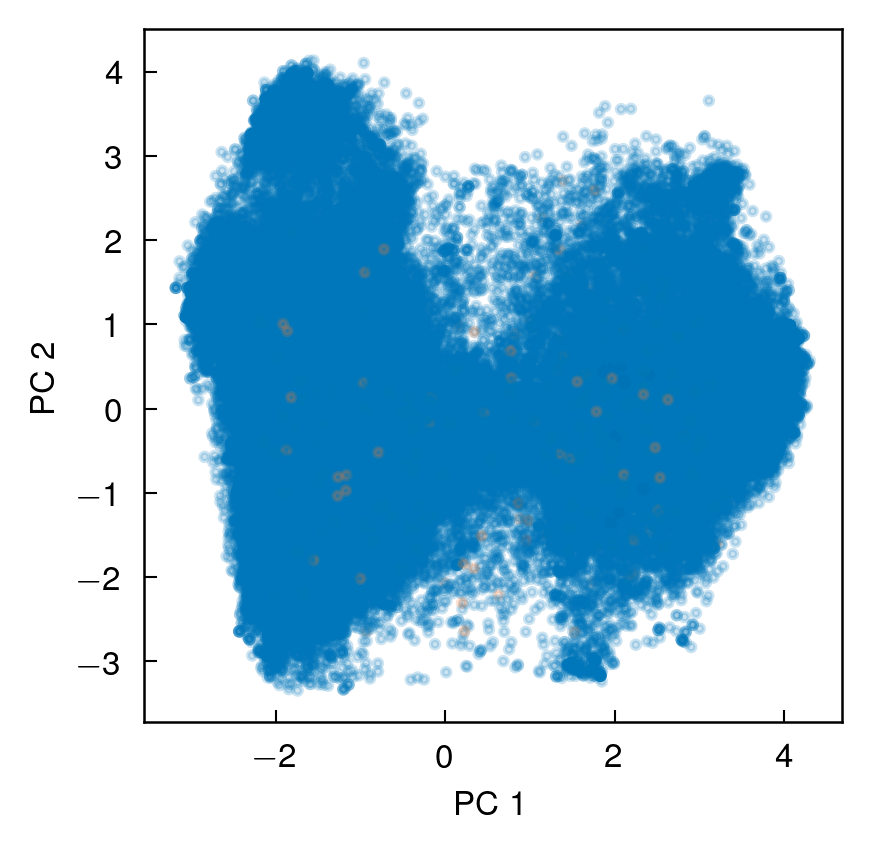

In [61]:
fig = plt.figure(dpi=300)
ax = plt.gca()
cmap = mpl.cm.get_cmap("tol:vibrant")
sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=clustering.labels_, alpha=0.2, cmap=cmap)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

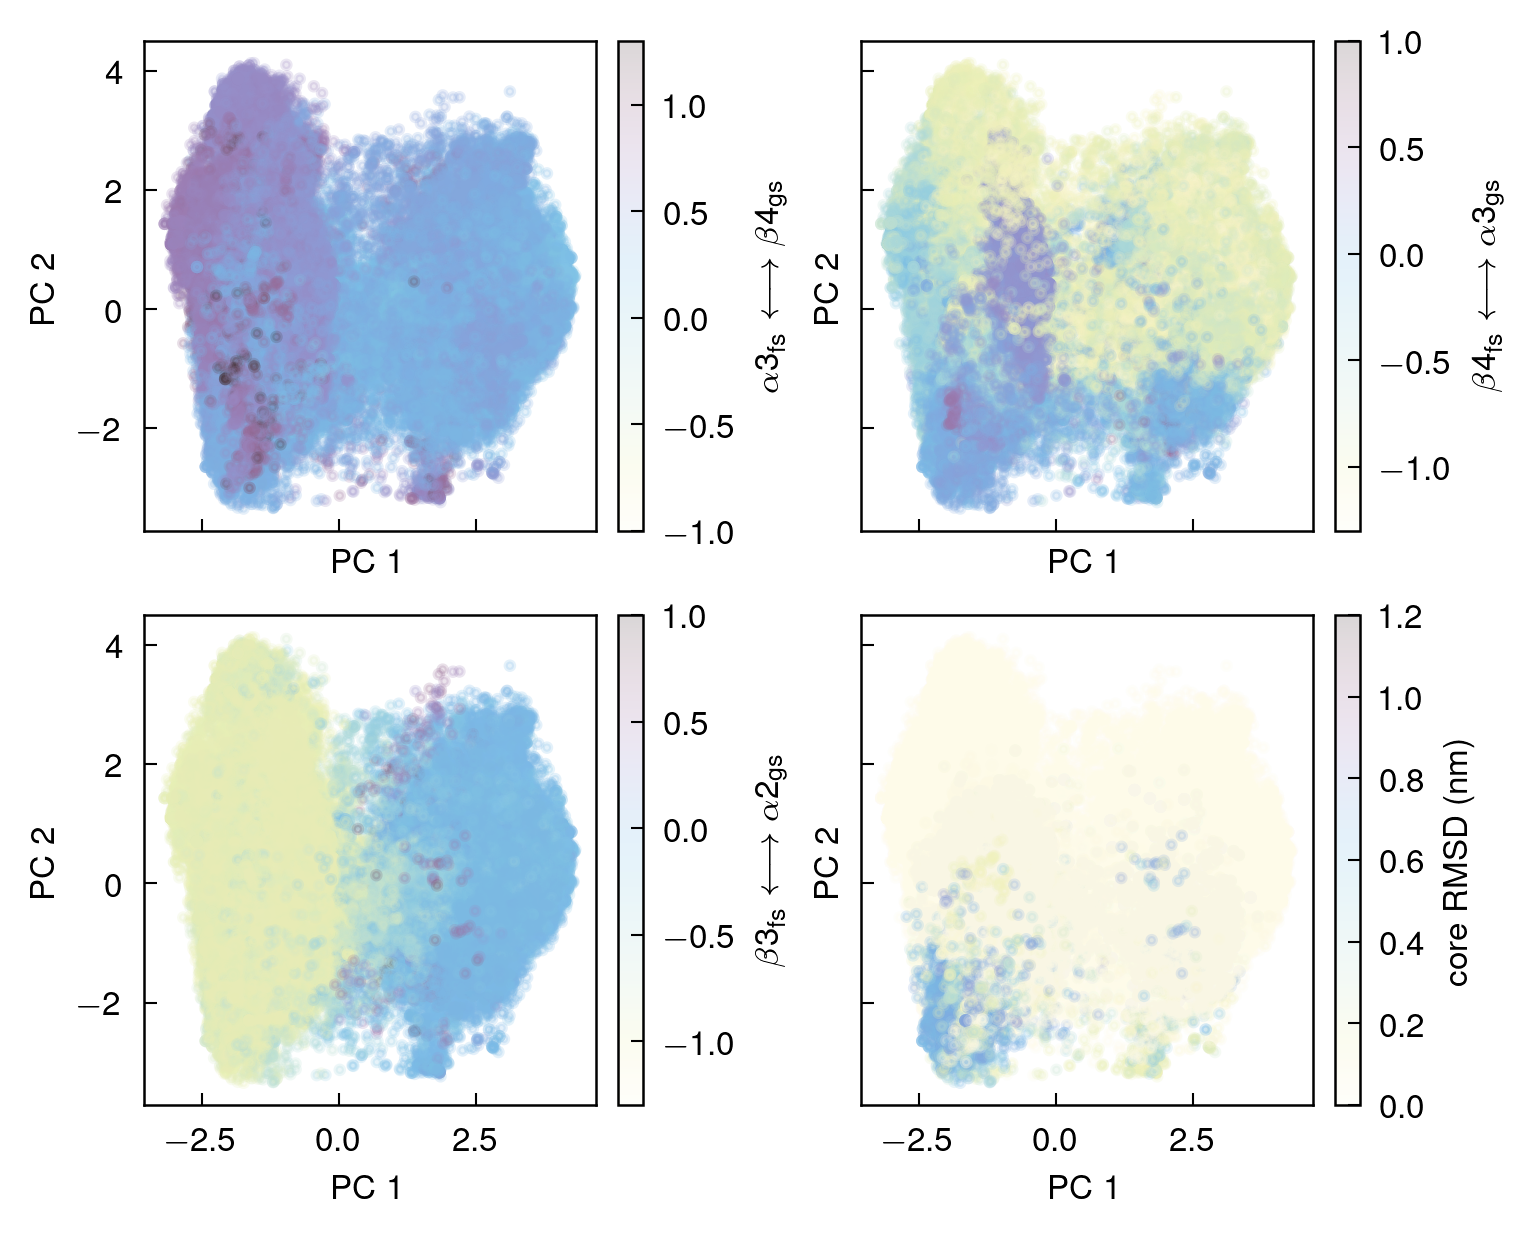

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(5, 4), dpi=300, sharex=True, sharey=True, constrained_layout=True)
cvs = [r_rmsds_arr, c_green_arr, c_blue_arr, c_orange_arr]
for ax, name, cv in zip(axes.flat, names, cvs):
    sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=cv[q_inds[2]], alpha=0.2, cmap="iridescent", vmin=lims[name][0], vmax=lims[name][1])
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    plt.colorbar(sc, ax=ax, label=labels[name])

In [116]:
# cluster by Hamming distance
from sklearn.metrics import DistanceMetric

hamming = DistanceMetric.get_metric("hamming")
pair_dists = hamming.pairwise(dssp_tse, dssp_tse)

In [118]:
from sklearn.cluster import AgglomerativeClustering, KMeans

In [119]:
kmeans = KMeans(n_clusters=8).fit(ohe)

/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Proline states

In [31]:
from collections import OrderedDict
from itertools import product

In [32]:
p63_cis_arr = np.ravel(p63_cis)
p70_cis_arr = np.ravel(p70_cis)
p71_cis_arr = np.ravel(p71_cis)
p72_cis_arr = np.ravel(p72_cis)

# assign proline states
dtraj = np.zeros_like(p63_cis_arr, dtype=int)
state_dict = OrderedDict()
fn_seq_iterator = product([lambda x: x, np.logical_not], repeat=4)
for i, (state, fn_seq) in enumerate(zip(product("CT", repeat=4), fn_seq_iterator)):
    # fn_seq is something like (Identity, ~, Identity, ~)
    seq = fn_seq[0](p63_cis_arr) & fn_seq[1](p70_cis_arr) & fn_seq[2](p71_cis_arr) & fn_seq[3](p72_cis_arr)
    state_name = "".join(state)
    print(f"{state_name}: {np.count_nonzero(seq) / len(seq) * 100:6.3f}%")
    state_dict[state_name] = i
    dtraj[seq] = i

CCCC:  0.000%
CCCT:  0.016%
CCTC:  0.013%
CCTT:  0.565%
CTCC:  0.001%
CTCT:  0.601%
CTTC:  0.080%
CTTT:  5.274%
TCCC:  0.000%
TCCT:  0.079%
TCTC:  0.059%
TCTT:  3.633%
TTCC:  0.004%
TTCT:  3.089%
TTTC:  0.710%
TTTT: 85.875%


In [33]:
print(state_dict)

OrderedDict([('CCCC', 0), ('CCCT', 1), ('CCTC', 2), ('CCTT', 3), ('CTCC', 4), ('CTCT', 5), ('CTTC', 6), ('CTTT', 7), ('TCCC', 8), ('TCCT', 9), ('TCTC', 10), ('TCTT', 11), ('TTCC', 12), ('TTCT', 13), ('TTTC', 14), ('TTTT', 15)])


In [34]:
dtraj

array([15, 15, 15, ..., 15, 15, 15])

In [35]:
def make_basis(dtraj, traj_lens):
    basis_arr = make_sparse_basis(dtraj)
    basis = []
    curr = 0
    for t_len in traj_lens:
        basis.append(basis_arr[curr : curr + t_len])
        curr += t_len
    return basis


def compute_transition_matrix(basis, weights, lag):
    C0 = 0.0
    Ct = 0.0
    test_basis = basis
    for w, x, y in zip(weights, basis, test_basis):
        wx = scipy.sparse.diags(w) @ x
        C0 += wx[:-lag].T @ y[:-lag]
        Ct += wx[:-lag].T @ y[lag:]
    return scipy.sparse.linalg.inv(C0) @ Ct

In [36]:
traj_lens = [len(traj) for traj in c_green]
basis = make_basis(dtraj, traj_lens)
t_mats = []
for w, lag in zip(weights, lags):
    t_mats.append(compute_transition_matrix(basis, w, lag))

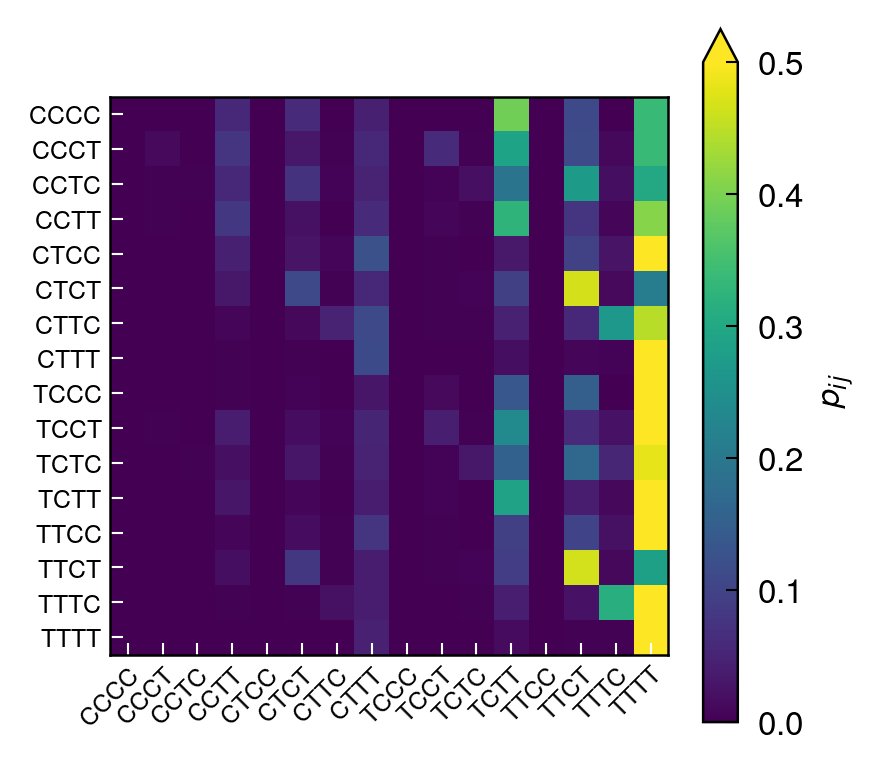

In [37]:
f = plt.figure(dpi=300)
plt.imshow(t_mats[0].A, vmin=0, vmax=0.5)
plt.colorbar(label=r"$p_{ij}$", extend="max")
ax = plt.gca()
ax.set_yticks(np.arange(16), state_dict.keys(), fontsize=6, fontfamily="monospace")
ax.set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)
ax.tick_params(color="white", pad=2)

In [57]:
# (TTCT -> TTTT) x (TTCT -> TTTT)
tmat = t_mats[0]
p1 = tmat[state_dict['TTCT'], state_dict['TTTT']] 
p2 = tmat[state_dict['TTTC'], state_dict['TTTT']]
p3 = tmat[state_dict['TTCC'], state_dict['TTTT']]
print(p1, p2, p1 * p2, p3)

0.2841436466239794 0.5466867682249931 0.15533757188452776 0.674198940399566


In [62]:
# (TTCT -> TTTT) x (TTCT -> TTTT)
tmat = t_mats[2]
p1 = tmat[state_dict['TTCT'], state_dict['TTTT']] 
p2 = tmat[state_dict['TTTC'], state_dict['TTTT']]
p3 = tmat[state_dict['TTCC'], state_dict['TTTT']]
print(p1, p2, p1 * p2, p3)

0.48800948511517833 0.8242268238115983 0.4022305079064169 0.7749479830042129


In [60]:
# (TTCC -> TTTC) x (TTTC -> TTTT)
tmat = t_mats[0]
p1 = tmat[state_dict['TTTT'], state_dict['TTCT']] 
p2 = tmat[state_dict['TTTT'], state_dict['TTTC']]
p3 = tmat[state_dict['TTTT'], state_dict['TTCC']]
print(p1, p2, p1 * p2, p3)

0.0031415531445335996 0.003294760585075884 1.0350665476530506e-05 1.600590019205807e-05


In [61]:
# (TTCC -> TTTC) x (TTTC -> TTTT)
tmat = t_mats[2]
p1 = tmat[state_dict['TTTT'], state_dict['TTCT']] 
p2 = tmat[state_dict['TTTT'], state_dict['TTTC']]
p3 = tmat[state_dict['TTTT'], state_dict['TTCC']]
print(p1, p2, p1 * p2, p3)

0.0023336226470354387 0.0043064246028514655 1.0049569980964775e-05 1.2080489715042345e-05


In [38]:
from itertools import combinations

In [39]:
def cis_transitions(tmat, rev=False):
    for ids in combinations(range(4), 2):
        single_cis_0, single_cis_1, double_cis = ['T', 'T', 'T', 'T'], ['T', 'T', 'T', 'T'], ['T', 'T', 'T', 'T'] 
        single_cis_0[ids[0]] = 'C'
        single_cis_1[ids[1]] = 'C'
        double_cis[ids[0]] = 'C'
        double_cis[ids[1]] = 'C'
        single_cis_0 = "".join(single_cis_0)
        single_cis_1 = "".join(single_cis_1)
        double_cis = "".join(double_cis)
        
        print(f"State 1: {single_cis_0}\tState 2: {single_cis_1}")

        if rev:
            tmat = tmat.T
        p0 = tmat[state_dict[single_cis_0], state_dict['TTTT']] 
        p1 = tmat[state_dict[single_cis_1], state_dict['TTTT']]
        p_joint = tmat[state_dict[double_cis], state_dict['TTTT']]
        print(f"\tState 1->TTTT: {p0:4>.3e}")
        print(f"\tState 2->TTTT: {p1:4>.3e}")
        print(f"\tProduct:       {p0 * p1:4>.3e}")
        print(f"\tJoint  ->TTTT: {p_joint:4>.3e}")
        print(f"\tjoint/product: {p_joint / (p0 * p1):4>.3f}")

In [40]:
cis_transitions(t_mats[0])
print("\n\n")
cis_transitions(t_mats[0], rev=True)

State 1: CTTT	State 2: TCTT
	State 1->TTTT: 8.516e-01
	State 2->TTTT: 5.762e-01
	Product:       4.907e-01
	Joint  ->TTTT: 4.096e-01
	joint/product: 0.835
State 1: CTTT	State 2: TTCT
	State 1->TTTT: 8.516e-01
	State 2->TTTT: 2.841e-01
	Product:       2.420e-01
	Joint  ->TTTT: 2.102e-01
	joint/product: 0.869
State 1: CTTT	State 2: TTTC
	State 1->TTTT: 8.516e-01
	State 2->TTTT: 5.467e-01
	Product:       4.655e-01
	Joint  ->TTTT: 4.458e-01
	joint/product: 0.958
State 1: TCTT	State 2: TTCT
	State 1->TTTT: 5.762e-01
	State 2->TTTT: 2.841e-01
	Product:       1.637e-01
	Joint  ->TTTT: 5.147e-01
	joint/product: 3.144
State 1: TCTT	State 2: TTTC
	State 1->TTTT: 5.762e-01
	State 2->TTTT: 5.467e-01
	Product:       3.150e-01
	Joint  ->TTTT: 4.817e-01
	joint/product: 1.529
State 1: TTCT	State 2: TTTC
	State 1->TTTT: 2.841e-01
	State 2->TTTT: 5.467e-01
	Product:       1.553e-01
	Joint  ->TTTT: 6.742e-01
	joint/product: 4.340



State 1: CTTT	State 2: TCTT
	State 1->TTTT: 4.610e-02
	State 2->TTTT: 1.4

In [41]:
cis_transitions(t_mats[1])
print("\n")
cis_transitions(t_mats[1], rev=True)

State 1: CTTT	State 2: TCTT
	State 1->TTTT: 8.839e-01
	State 2->TTTT: 6.617e-01
	Product:       5.849e-01
	Joint  ->TTTT: 5.352e-01
	joint/product: 0.915
State 1: CTTT	State 2: TTCT
	State 1->TTTT: 8.839e-01
	State 2->TTTT: 3.769e-01
	Product:       3.331e-01
	Joint  ->TTTT: 2.778e-01
	joint/product: 0.834
State 1: CTTT	State 2: TTTC
	State 1->TTTT: 8.839e-01
	State 2->TTTT: 6.976e-01
	Product:       6.166e-01
	Joint  ->TTTT: 6.021e-01
	joint/product: 0.976
State 1: TCTT	State 2: TTCT
	State 1->TTTT: 6.617e-01
	State 2->TTTT: 3.769e-01
	Product:       2.494e-01
	Joint  ->TTTT: 6.422e-01
	joint/product: 2.575
State 1: TCTT	State 2: TTTC
	State 1->TTTT: 6.617e-01
	State 2->TTTT: 6.976e-01
	Product:       4.616e-01
	Joint  ->TTTT: 5.760e-01
	joint/product: 1.248
State 1: TTCT	State 2: TTTC
	State 1->TTTT: 3.769e-01
	State 2->TTTT: 6.976e-01
	Product:       2.629e-01
	Joint  ->TTTT: 7.094e-01
	joint/product: 2.698


State 1: CTTT	State 2: TCTT
	State 1->TTTT: 4.624e-02
	State 2->TTTT: 1.44

In [63]:
import pyemma

In [64]:
lags

array([ 500, 1000, 2000])

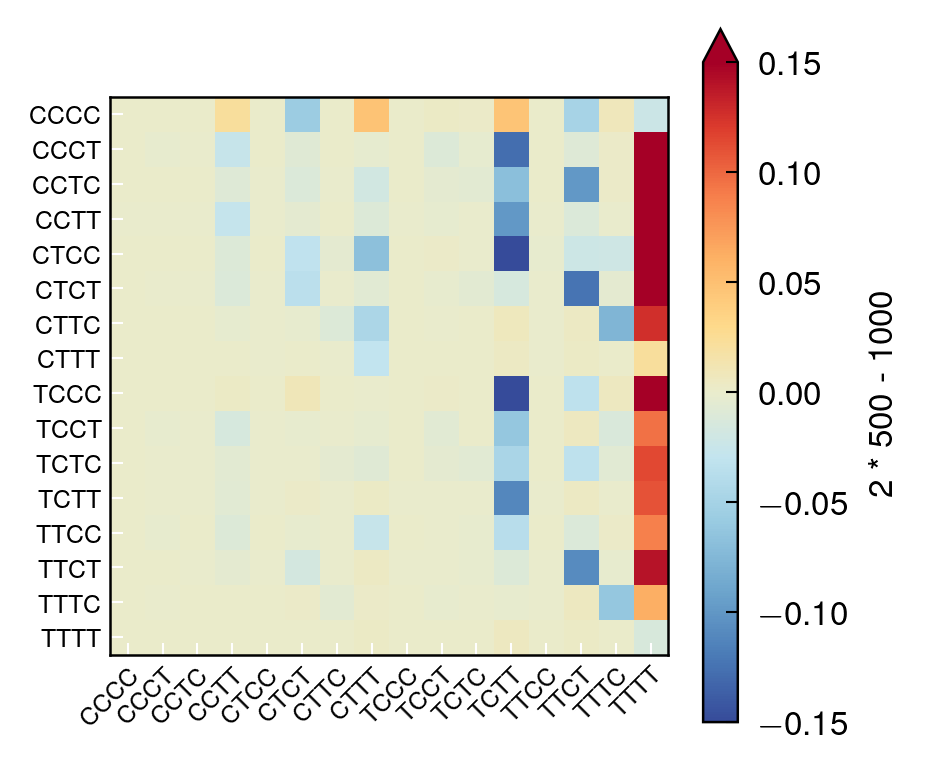

In [42]:
diff = (t_mats[0] @ t_mats[0]) - t_mats[1]
f = plt.figure(dpi=300)
plt.imshow(diff.A, vmin=-0.15, vmax=0.15, cmap='sunset')
plt.colorbar(label="2 * 500 - 1000", extend="max")
ax = plt.gca()
ax.set_yticks(np.arange(16), state_dict.keys(), fontsize=6, fontfamily="monospace")
ax.set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)
ax.tick_params(color="white", pad=2)

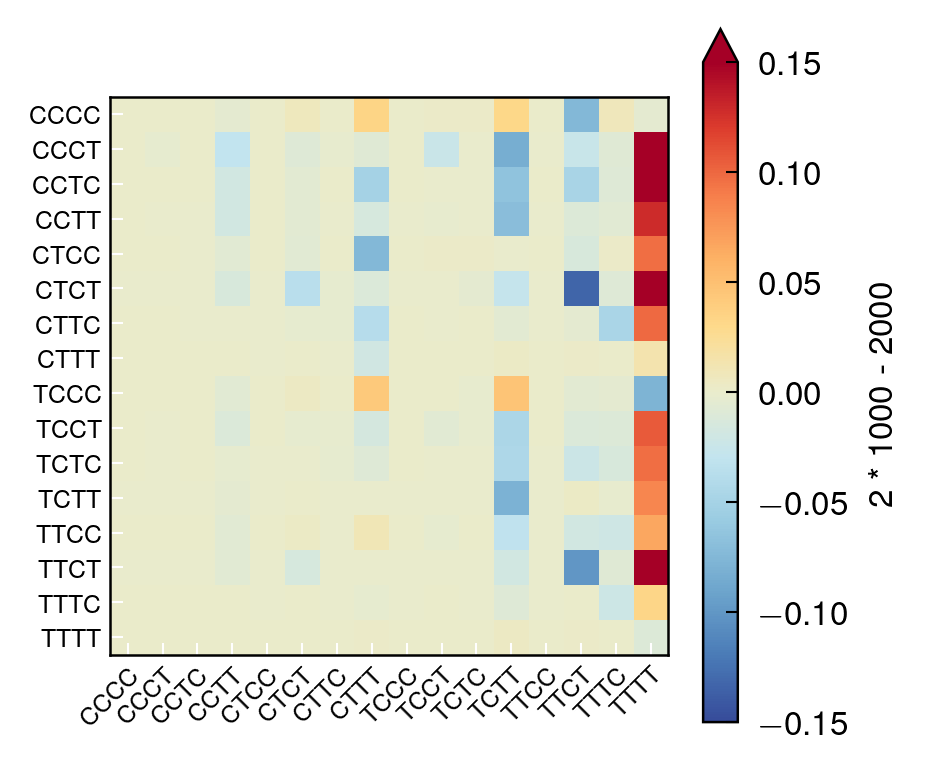

In [43]:
diff = (t_mats[1] @ t_mats[1]) - t_mats[2]
f = plt.figure(dpi=300)
plt.imshow(diff.A, vmin=-0.15, vmax=0.15, cmap='sunset')
plt.colorbar(label="2 * 1000 - 2000", extend="max")
ax = plt.gca()
ax.set_yticks(np.arange(16), state_dict.keys(), fontsize=6, fontfamily="monospace")
ax.set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)
ax.tick_params(color="white", pad=2)

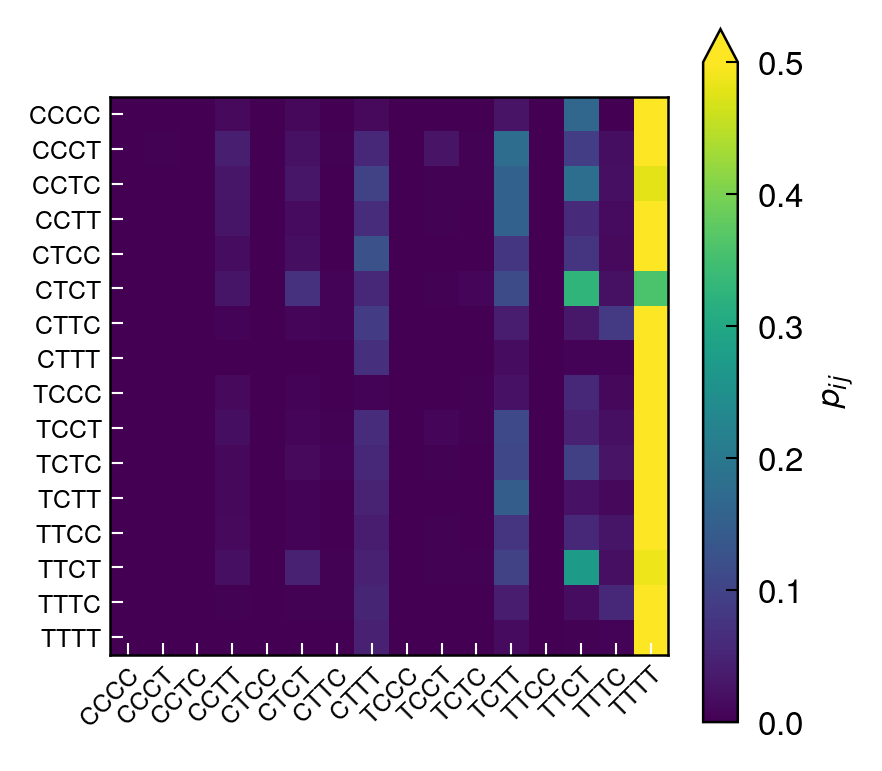

In [44]:
f = plt.figure(dpi=300)
plt.imshow(t_mats[2].A, vmin=0, vmax=0.5)
plt.colorbar(label=r"$p_{ij}$", extend="max")
ax = plt.gca()
ax.set_yticks(np.arange(16), state_dict.keys(), fontsize=6, fontfamily="monospace")
ax.set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)
ax.tick_params(color="white", pad=2)

In [45]:
def compute_cis_state_frac(dtraj, weights=None):
    if weights is None:
        weights = np.ones_like(dtraj, dtype=float)
    ans = np.zeros(16, dtype=float)
    for i in range(16):
        ans[i] = np.sum(np.where(dtraj == i, weights, 0))
    return ans / np.sum(weights)

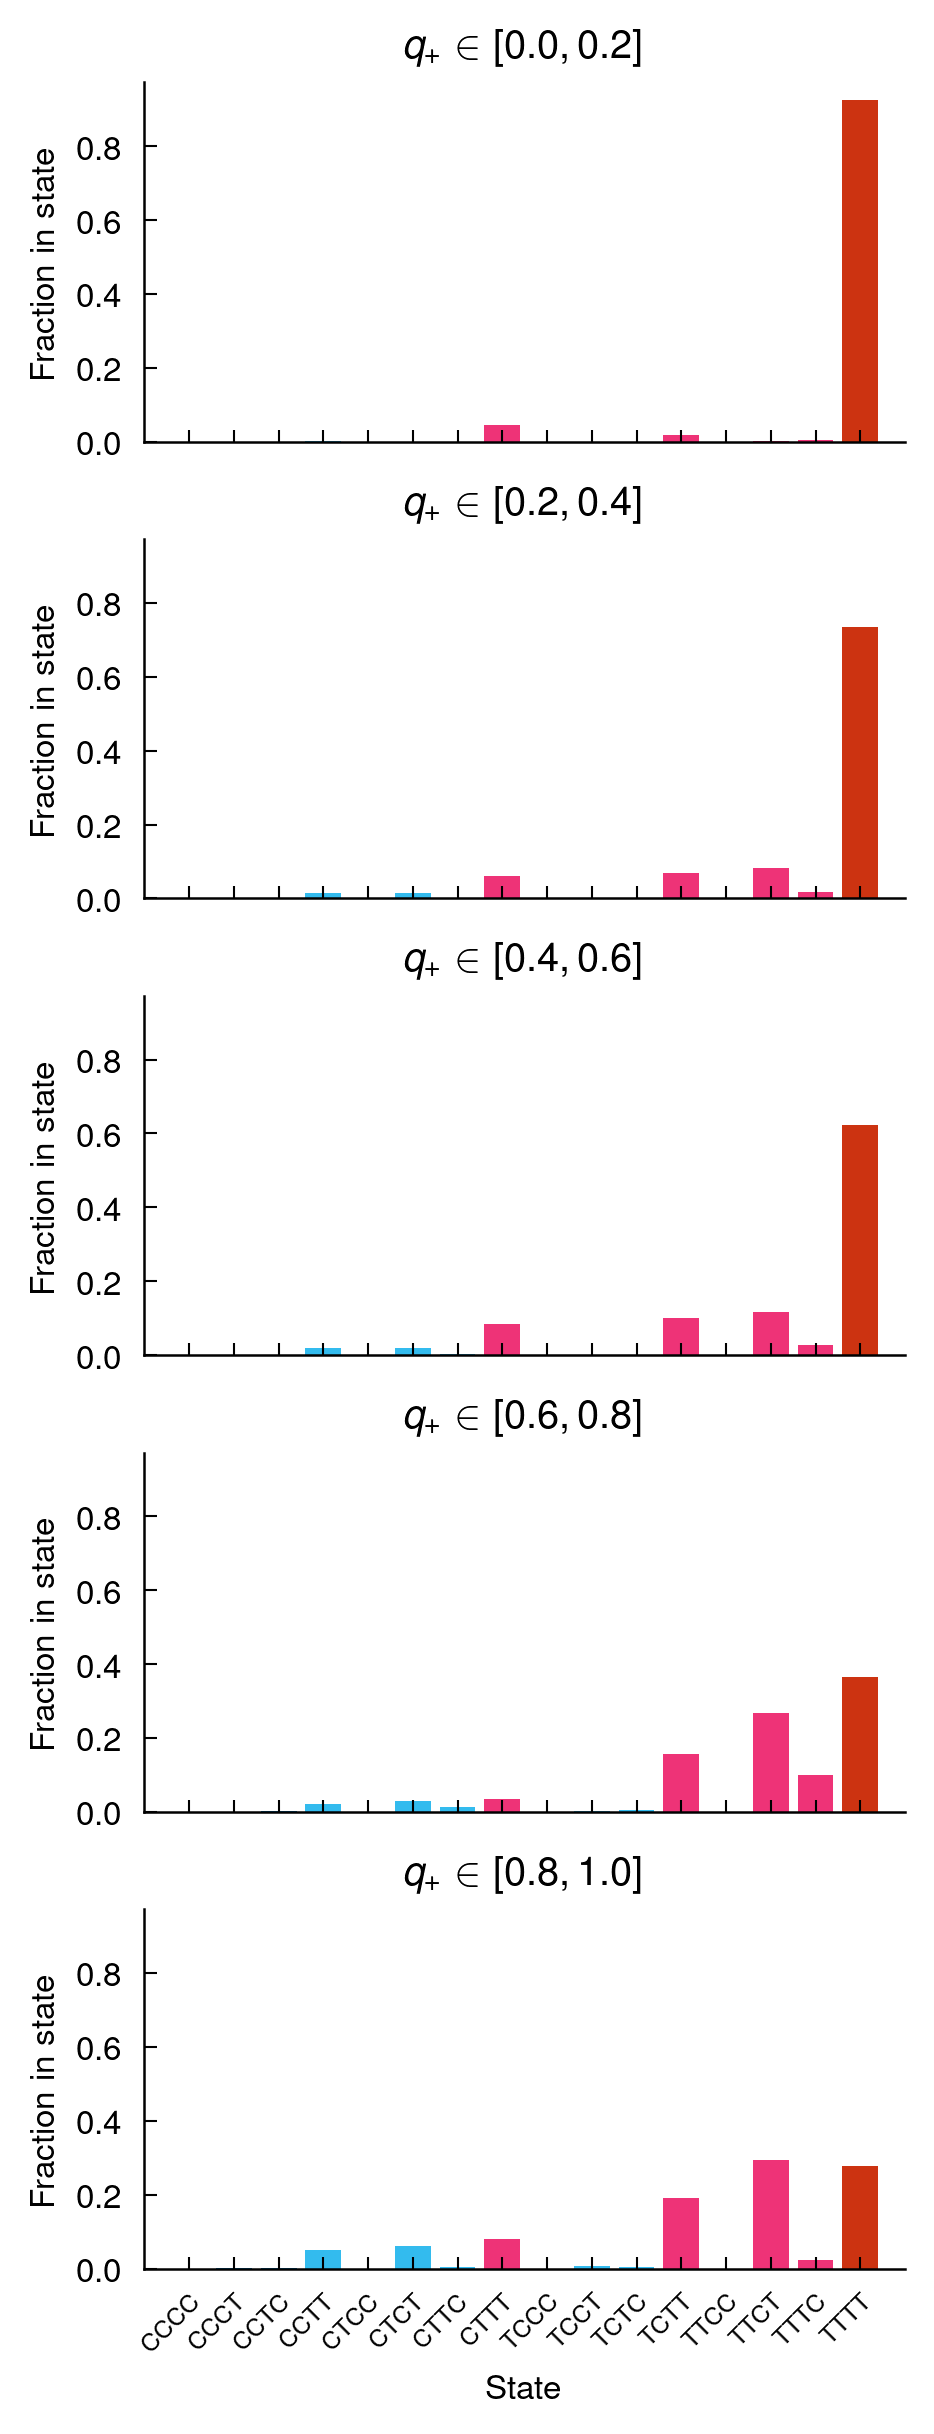

In [46]:
steps, q_inds = bin_inds(qp_gs2fs, qstep=0.2, low=0, hi=1)

fig, axes = plt.subplots(
    nrows=5, figsize=(3, 8), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
# color by number of cis
colors = []
for state in state_dict.keys():
    colors.append(f"C{state.count('T')}")

for ax, step, inds in zip(axes.flat, steps, q_inds):
    fraction = compute_cis_state_frac(dtraj[inds], weights=np.ravel(weights[1])[inds])
    ax.bar(range(16), fraction, align="center", color=colors)
    ax.set_xlim([-1, 16])
    ax.set_title(f"$q_+ \\in [{step:.1f}, {step + 0.2:.1f}]$")
    ax.set_xlabel("State")
    ax.set_ylabel("Fraction in state")
    sns.despine(ax=ax, top=True, right=True, bottom=False, left=False)
    ax.label_outer()

axes[-1].set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)